# Import data

In [1]:
#First we have the importation part so we need some library to import locally our data
import pandas as pd
import os
import glob

#And the rest of the imports for the data analysis
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

import astral
import datetime
from astral import sun
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
import pytz
from datetime import tzinfo
import math

# Preparation

## 1. Standardized stop datamade available by the Stanford Open Policing Projec

In [2]:
# Let's create a function that does take the columns we want in our analysis and return a DataFrame with those columns needed.

FOLDER = 'raw/'
csvfiles = glob.glob(os.path.join(FOLDER, '*.csv'))

# First let's import the data with the required columns for our analysis 
data = pd.DataFrame(columns=['date', 'time', 'county_name', "state", 'subject_race', 'officer_race', 'search_conducted', 'contraband_found'])

chunksize = 10 ** 6
for csvfile in csvfiles:
    for chunk in pd.read_csv(csvfile, usecols=lambda x: x in ['date', 'time', 'county_name', 'subject_race', 'officer_race', 'search_conducted', 'contraband_found'] \
                     , chunksize=chunksize, low_memory=False, error_bad_lines = False):
        states = [csvfile[-6:-4].upper() for i in range(len(chunk))]
        chunk.insert(2, "state", states)
        data = pd.concat([data, chunk], axis=0 , ignore_index=True)
        
# Remove fields where race unknown, asian/pasific islander or other
races = ['white', 'black', 'hispanic']
data = data[data['subject_race'].isin(races) & data['officer_race'].isin(races)]

In [3]:
data.head(10)

,contraband_found,county_name,date,officer_race,search_conducted,state,subject_race,time
0,NaN,NaN,2008-10-10,hispanic,NaN,CA,hispanic,NaN
1,NaN,NaN,2008-10-10,white,NaN,CA,hispanic,NaN
2,NaN,NaN,2008-10-10,white,NaN,CA,hispanic,NaN
3,NaN,NaN,2008-10-10,white,NaN,CA,white,NaN
4,NaN,NaN,2008-10-10,white,NaN,CA,hispanic,NaN
5,NaN,NaN,2008-10-10,white,NaN,CA,hispanic,NaN
6,NaN,NaN,2008-10-10,white,NaN,CA,black,NaN
7,NaN,NaN,2008-10-10,hispanic,NaN,CA,black,NaN
8,NaN,NaN,2008-10-10,white,NaN,CA,black,NaN
9,NaN,NaN,2008-10-10,hispanic,NaN,CA,black,NaN


## 2. Census dataset
A dataset from the US governement census data will be loaded. This dataset contains the Decennial Census datas.
The dataset contains detailed tables focusing on race. The race categories include eighteen Asian groups and twelve Native Hawaiian and Other Pacific Islander groups. It presents data for the United States, the 50 states, and the District of Columbia.

For each US County, we will be able to know the number of black and whites living in the County. It is important to notice that each County report census data in different ways, hence comparing County/State census data is not always relevant. Hence the conclusions made with those datas must be done carfully.

In [4]:
# Read the Census datas
# Read from the API
df = pd.read_json("https://api.census.gov/data/2010/dec/sf1?get=P001001,P003002,P003003,NAME&for=county:*")

# Set the column names
new_header = df.iloc[0] 
df = df[1:] 
new_header[0] = 'Total'
new_header[1] = 'White'
new_header[2] = 'Black'
df.columns = new_header #set the header row as the df header

# Display the first rows
df.head(10)

,Total,White,Black,NAME,state,county
1,125744,96344,8019,"Sebastian County, Arkansas",05,131
2,17058,11949,734,"Sevier County, Arkansas",05,133
3,17264,16582,93,"Sharp County, Arkansas",05,135
4,12394,11995,11,"Stone County, Arkansas",05,137
5,41639,26276,13721,"Union County, Arkansas",05,139
6,17295,16598,68,"Van Buren County, Arkansas",05,141
7,203065,162253,6006,"Washington County, Arkansas",05,143
8,77076,70425,3074,"White County, Arkansas",05,145
9,22185,19226,307,"Yell County, Arkansas",05,149
10,21419,13854,195,"Colusa County, California",06,011


In [5]:
# Print some stats about the dataset

# The dataframe contains Counties and "independent cities" that are not part of any counties. (i.e. Carson City, from Nevada)
print("The length of the dataframe is:", len(df))
print("The total number of black inhabitants is ", pd.to_numeric(df['Black']).sum())
print("The total number of white inhabitants is ", pd.to_numeric(df['White']).sum())
print("The biggest county is:" + df.loc[(pd.to_numeric(df['Total'])).argmax()]['NAME'] + " with", df.loc[(pd.to_numeric(df['Total'])).argmax()]['Total'], "inhabitants.")

The length of the dataframe is: 3221
The total number of black inhabitants is  39390817
The total number of white inhabitants is  226378365
The biggest county is:Los Angeles County, California with 9818605 inhabitants.


In [6]:
# Create a function to query the Census dataset

# Given a county name and a state name, returns the number of 
# total polulation, number of blacks and number of whites.
def getStatsByCounty(countyName, stateName, df):
    # Split the NAME column in "County/City Name" and "State"
    new_df = df.copy()
    new_df[['County_name', 'State_name']] = df['NAME'].str.split(',', 1, expand=True)
    matches = new_df[new_df['County_name'].str.contains(countyName)].copy()
    if(len(matches) == 0):
        # Try to remove dots from the county name 
        # i.e. "St. Johns County" is "St Johns counts" in the police dataset
        matches = new_df[new_df['County_name'].str.replace('.', '').str.contains("(?i)"+countyName)].copy()
            
    matches = matches[matches['State_name'].str.contains("(?i)"+stateName)].copy()
    
    matches['Total'] = pd.to_numeric(matches['Total'])
    matches['White'] = pd.to_numeric(matches['White'])
    matches['Black'] = pd.to_numeric(matches['Black'])
    
    if(len(matches) == 0):
        print("[getStatsByCounty] Error: County not found: ", countyName, " ", stateName)
        return;
    if(len(matches) == 1):
        return {'total': matches['Total'].values[0], 
                'white': matches['White'].values[0],
                'black': matches['Black'].values[0], 
               }
    else:
        print("[getStatyByCount] Error: Too many matches: ", countyName)
        print(matches[['County_name', 'State_name']])
        return;

# Display the stats for new york. No states are specified since there is only one new york!
getStatsByCounty('new york', '', df)

{'total': 1585873, 'white': 911073, 'black': 246687}

The Census dataset can now be queried with getStatsByCounty function.
We only get the numbre of black and white prople. The census datas does not provides the number of "hispanics race", but only the number of persons with "hispanic origin". Hence a black or a white person can also have hispanic origins, making it tricky to analyse.

# Part 1 : Veil of darkness test

In [7]:
# First let's take from the data the columns we're interested in for this analysis
columns = ['date', 'time', 'state', 'subject_race', 'officer_race']
df_veil = data[columns]

# And remove the columns where there are no informations about the subject race, the officer race and the time and date of the stop as we will base our analysis on those
df_veil = df_veil.dropna(subset=['date', 'time', 'subject_race', 'officer_race'])

# The dataset contain some data about Asian/Pacifican race people but we will remove them from our analysis as they are only a small fraction 
# of the population. For the Veil of darkness test we will also remove hispanic drivers and thus officer because the ethnicity of Hispanic drivers
# is not always apparent, even in daylight hours
df_veil = df_veil.query('subject_race in ["white", "black"] and officer_race in ["white", "black"]')

# Finally we'll convert the date to datetime format for further work with it
# Convert date to datetime
df_veil['date'] = pd.to_datetime(df_veil['date'], format = "%Y/%m/%d")

df_veil

,date,time,state,subject_race,officer_race
365925,2010-01-06,16:14:43,FL,white,black
365926,2010-01-08,19:39:31,FL,white,white
365927,2010-01-11,11:56:34,FL,white,white
365930,2010-01-15,09:18:02,FL,white,white
365934,2010-01-15,13:55:22,FL,black,white
...,...,...,...,...,...
26136752,2015-09-09,08:00:00,WA,white,white
26136756,2015-09-18,09:00:00,WA,white,white
26136758,2015-09-18,10:00:00,WA,white,white
26136759,2015-09-20,12:00:00,WA,white,white


In [8]:
# To test for the veil of darkness we will need to search for the sunset time at each day of the year at each state in our analysis. 
# As it's a big search we need to reduce computation time and because sunset is at the same time though the year, we can safely remove
# the year of the stop to keep only the day and month of the stop to then search for the sunset at this time of the year.
df_veil['date'] = df_veil['date'].apply(lambda x: x.strftime('%m-%d'))
df_veil

,date,time,state,subject_race,officer_race
365925,01-06,16:14:43,FL,white,black
365926,01-08,19:39:31,FL,white,white
365927,01-11,11:56:34,FL,white,white
365930,01-15,09:18:02,FL,white,white
365934,01-15,13:55:22,FL,black,white
...,...,...,...,...,...
26136752,09-09,08:00:00,WA,white,white
26136756,09-18,09:00:00,WA,white,white
26136758,09-18,10:00:00,WA,white,white
26136759,09-20,12:00:00,WA,white,white


In [9]:
# Also, for the sunset search, we will need a complete date with also the year, we will add 2016 to the date as it's a year that goes until 
# the 29th of february and this date is in our dataset.
df_veil['date'] = df_veil['date'].apply(lambda x : '2016-'+x)

# And we can put back the date in datetime format
df_veil['date'] = pd.to_datetime(df_veil['date'], format="%Y/%m/%d")
df_veil

,date,time,state,subject_race,officer_race
365925,2016-01-06,16:14:43,FL,white,black
365926,2016-01-08,19:39:31,FL,white,white
365927,2016-01-11,11:56:34,FL,white,white
365930,2016-01-15,09:18:02,FL,white,white
365934,2016-01-15,13:55:22,FL,black,white
...,...,...,...,...,...
26136752,2016-09-09,08:00:00,WA,white,white
26136756,2016-09-18,09:00:00,WA,white,white
26136758,2016-09-18,10:00:00,WA,white,white
26136759,2016-09-20,12:00:00,WA,white,white


In [10]:
# Let's now create our sunset dataset where we need the sunset for each state and each day of the year
df_sunset = df_veil.groupby(['state', 'date']).count().reset_index()[['state', 'date']]

# Let's find the states we have in our dataset to then find the geocode location with help of the geolocator library. This geocode will help us find the timezone 
# of the US we're in and also the sunset time with help of the astral library
states = df_sunset['state'][df_sunset['state'].duplicated(keep='first') == False].to_list()
locations = []
timezones = []
astr = []
# Let's find all locations of the states
for i in states  :
    locations.append(geolocator.geocode(i+' USA'))
    
# And then find the timezone and the astral object of this location
for location in locations : 
    timezones.append(pytz.timezone(tf.timezone_at(lng=location.longitude, lat=location.latitude)))
    astr.append(astral.Observer(latitude = location.latitude, longitude = location.longitude))

# Finally we need to add sunset time of each state and date in the DataFrame where stops have been grouped by state and date
sunset=[]
for row in df_sunset.iterrows() :
    index = states.index(row[1]['state'])
    sunset.append(sun.sunset(astr[index], date=row[1]['date'], tzinfo = timezones[index]))

# And append it to the sunset DataFrame with the date in datetime format
df_sunset['sunset']=[sunset[i].time() for i in range(len(sunset))]
df_sunset['date']=pd.to_datetime(df_sunset['date'], format = "%Y/%m/%d")

df_sunset

,state,date,sunset
0,FL,2016-01-01,17:41:45.493173
1,FL,2016-01-02,17:42:26.700927
2,FL,2016-01-03,17:43:08.686556
3,FL,2016-01-04,17:43:51.408405
4,FL,2016-01-05,17:44:34.824605
...,...,...,...
1825,WA,2016-12-27,16:17:01.678300
1826,WA,2016-12-28,16:17:49.681238
1827,WA,2016-12-29,16:18:40.080350
1828,WA,2016-12-30,16:19:32.820701


In [11]:
# Let's look at our sunset dataset and see when are the minimum and maximum values for sunset in our choosen states  
sunset_min = df_sunset['sunset'].min()
sunset_max = df_sunset['sunset'].max()
print(f'Minimum sunset time  {sunset_min}, Maximum sunset time : {sunset_max}')

Minimum sunset time  16:10:11.928757, Maximum sunset time : 21:13:45.831757


In [12]:
# As we have still a big dataset and the veil of darkness analysis takes only time that are maximum 2 hours before sunset 
# and maximum 2h30 after sunset. We take a bigger time after sunset because of the 30 inutes window time between sunset and dusk.
length_before = len(df_veil)
df_veil['time'] = [datetime.datetime.strptime(df_veil['time'].iloc[i], '%H:%M:%S') for i in range(len(df_veil))]
df_veil = df_veil.loc[(df_veil['time']>datetime.datetime.strptime("14:10:00", '%H:%M:%S')) & (df_veil['time']<(datetime.datetime.strptime("23:43:00", '%H:%M:%S')))]
length_after = len(df_veil)

print(f'The dataset has been shorten by {length_before-length_after} rows and we now have {length_after} rows.')

The dataset has been shorten by 4583820 rows and we now have 3187171 rows.


In [13]:
# We will just need to further modify the DataFrame to have the time as a pydatetime format and the date as a datetime
df_veil['time']= [df_veil['time'].iloc[i].to_pydatetime() for i in range(len(df_veil))]
df_veil['date'] = [df_veil.iloc[i]['date'].strftime("%Y-%m-%d") for i in range(len(df_veil))]

In [ ]:
# Now let's define the DataFrame we will work on for the analysis. This DataFrame will contain the subject race, the officer race and the time
# to sunset. If the stop happened 2 hours before sunset, the time_sunset column will be -7200 as we change it to seconds. 

#To create this Dat$aFrame, we will need to iterate over each row of the df_veil DataFrame to find the corresponding state and day of the year in
# the sunset DataFrame to compare the time of the stop to the time of the sunset at this place and time of the year.


df_veil_sunset = pd.DataFrame(columns = ['subject_race', 'officer_race', 'time_sunset'])
for row in df_veil.iterrows() :
    sunset = df_sunset.loc[(df_sunset['state'] == row[1]['state']) & (df_sunset['date'] == row[1]['date']), 'sunset'].values[0].strftime("%H:%M:%S")
    time_sunset = (row[1]['time'] - datetime.datetime.strptime(sunset, '%H:%M:%S')).total_seconds()
    df_veil_sunset = df_veil_sunset.append({'subject_race' : row[1]['subject_race'], 'officer_race' : row[1]['officer_race'], 'time_sunset' : time_sunset}, ignore_index = True)

In [ ]:
df_veil_sunset.to_csv(r'data_clean/df_veil_sunset.csv', index=False)

In [14]:
df_veil_sunset = pd.read_csv('data_clean/df_veil_sunset.csv')
df_veil_sunset

,subject_race,officer_race,time_sunset
0,white,black,-5435.0
1,white,white,6763.0
2,white,white,18604.0
3,black,black,-11386.0
4,black,black,-9054.0
...,...,...,...
3187166,white,white,10488.0
3187167,white,white,14088.0
3187168,white,white,-10990.0
3187169,white,white,4264.0


In [15]:
# Now to start analysing the sunset Dataset we will remove first the data where the sunset doesn't lie in the the interval of 90 minutes 
# before sunset and 30 to 120 minutes after sunset. This will then allow us to compare stops before and after sunset. 
df_veil_sunset = df_veil_sunset.loc[(df_veil_sunset['time_sunset']>-5400) & (df_veil_sunset['time_sunset']<7200)]
df_veil_sunset = df_veil_sunset.loc[(df_veil_sunset['time_sunset']<0) | (df_veil_sunset['time_sunset']>1800)]

# Let's round time to the upper 10's of minutes
df_veil_sunset['time_sunset'] = df_veil_sunset['time_sunset'].apply(lambda x : int(math.ceil(x / 600.0)) * 10)

# We can now get the sum of the number of stops by subject race per officer race with the different time between sunset
df_veil_sunset = pd.get_dummies(df_veil_sunset, columns=['subject_race'])
df_veil_sunset=df_veil_sunset.groupby(['officer_race', 'time_sunset']).sum()

# In the plot we will use the number of stops as the size of the datapoints. We can thus add a column with the sum of sunset by row for indication
# in our DataFrame. We will also use percentage of total stops per time and per officer race to compare between driver's race. 
sum_row_list = [] #for the size of the rounds
sum_row = 0
for row in df_veil_sunset.iterrows() :
    sum_row = row[1]['subject_race_black']+row[1]['subject_race_white']
    row[1]['subject_race_black']/= sum_row
    row[1]['subject_race_white']/= sum_row
    sum_row_list.append(sum_row)
df_veil_sunset['sum_row']=sum_row_list
df_veil_sunset = df_veil_sunset.reset_index()

df_veil_sunset

,officer_race,time_sunset,subject_race_black,subject_race_white,sum_row
0,black,-80,0.269740,0.730260,6117.0
1,black,-70,0.266656,0.733344,6229.0
2,black,-60,0.271339,0.728661,5764.0
3,black,-50,0.263618,0.736382,5838.0
4,black,-40,0.277122,0.722878,5503.0
5,black,-30,0.276185,0.723815,5337.0
6,black,-20,0.277282,0.722718,4930.0
7,black,-10,0.276902,0.723098,5074.0
8,black,0,0.301558,0.698442,4364.0
9,black,40,0.277322,0.722678,2928.0


In [16]:
#Let's define a function to plot the veil of darkness test. We will add mean and standard deviations to the datapoints.

def draw(ax, df, race_officer, race_subject, sum_row_list, size) : 
    df_veil_draw = df.loc[df['officer_race']==race_officer]
    list_sizes = df_veil_draw['sum_row'].copy()
    list_sizes[:] = [x/size for x in list_sizes]
    ax.scatter(df_veil_draw['time_sunset'], df_veil_draw[race_subject], s=list_sizes)
    mean_before = df_veil_draw.loc[df_veil_draw['time_sunset']<=0].mean()[race_subject]
    mean_after = df_veil_draw.loc[df_veil_draw['time_sunset']>=30].mean()[race_subject]
    std_before = df_veil_draw.loc[df_veil_draw['time_sunset']<=0].std()[race_subject]
    std_after = df_veil_draw.loc[df_veil_draw['time_sunset']>=30].std()[race_subject]
    ax.hlines(mean_before, xmin=-80, xmax=0, colors='k', linestyles='solid')
    ax.hlines(mean_after, xmin=30, xmax=120, colors='k', linestyles='solid')
    ax.hlines(mean_before+std_before, xmin=-80, xmax=0, colors='k', linestyles='--')
    ax.hlines(mean_after+std_after, xmin=30, xmax=120, colors='k', linestyles='--')
    ax.hlines(mean_before-std_before, xmin=-80, xmax=0, colors='k', linestyles='--')
    ax.hlines(mean_after-std_after, xmin=30, xmax=120, colors='k', linestyles='--')
    ax.axvline(0)
    ax.axvline(30)
    ax.set_title(f'Officer : {race_officer}, Driver : {race_subject[13:]}')
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90, 120])
    return []

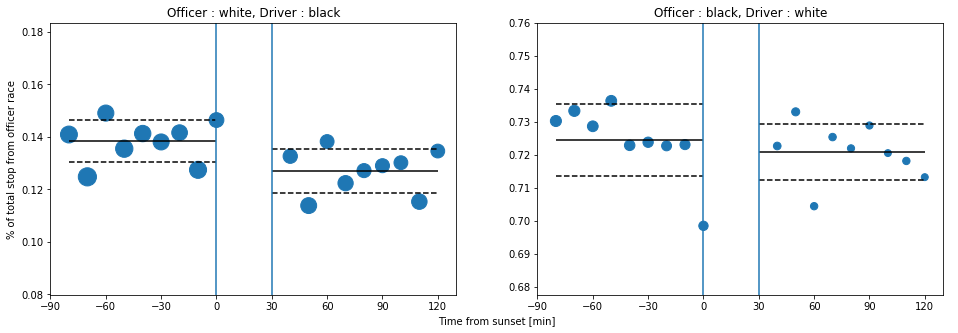

In [17]:
# Let's plot now the dataset
fig = plt.figure(figsize=(16, 5))

ax0 = fig.add_subplot(111)

ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')
ax0.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

#draw(ax1 , df_veil_sunset, 'white', 'subject_race_white', sum_row_list, 200)
draw(ax1, df_veil_sunset, 'white', 'subject_race_black', sum_row_list, 200)

draw(ax2 , df_veil_sunset, 'black', 'subject_race_white', sum_row_list, 50)
#draw(ax4 , df_veil_sunset, 'black', 'subject_race_black', sum_row_list, 50)

#ax3.set_xlabel('Time from sunset [min]')
#ax4.set_xlabel('Time from sunset [min]')
ax1.set_ylabel('% of total stop from officer race')
ax0.set_xlabel('Time from sunset [min]')
#ax3.set_ylabel('% of total stop from officer race')

#And save the figure for the report 
plt.savefig('veil_fig.eps')
plt.show()

In [18]:
#let's define now a function for the t-test for the difference in means
def ttest(data, races):
    df = pd.DataFrame(columns=['officer_race', 'driver_race', 'mean_before', 'mean_after', 't-statistic', 'p-value'])
    for officer_race in races:
        for driver_race in races :
            data_test = data.loc[data['officer_race']==officer_race]
            data_before = data_test.loc[data_test['time_sunset']<=0]['subject_race_'+driver_race]
            data_after = data_test.loc[data_test['time_sunset']>=30]['subject_race_'+driver_race]
            result = stats.ttest_ind(data_before, data_after)
            temp = pd.DataFrame([[officer_race, driver_race, data_before.mean(), data_after.mean(), result[0], result[1]]], columns=df.columns)
            df = pd.concat([df, temp], ignore_index=True)
    return df

In [19]:
#And now use it to test our data
races=['white', 'black']
ttest_veil = ttest(df_veil_sunset, races)
ttest_veil

,officer_race,driver_race,mean_before,mean_after,t-statistic,p-value
0,white,white,0.861658,0.872962,-2.921739,0.009980
1,white,black,0.138342,0.127038,2.921739,0.009980
2,black,white,0.724400,0.720917,0.755128,0.461144
3,black,black,0.275600,0.279083,-0.755128,0.461144


# 2. Stop proportions based on race

## 2.1 Data processing

Only keep the data needed for this part:

In [20]:
data_prop = data[['subject_race', 'officer_race']]
data_prop = data_prop.dropna()

data_prop.head(10)

,subject_race,officer_race
0,hispanic,hispanic
1,hispanic,white
2,hispanic,white
3,white,white
4,hispanic,white
5,hispanic,white
6,black,white
7,black,hispanic
8,black,white
9,black,hispanic


### a) Number of stops by officer race

In [21]:
# Count stops for each race in races.
# df: input dataframe; stats: output dataframe
# officer: officer race; races: list of subject races
def countStops(df, stats, officer, races):
    same_race = df[(df['officer_race'] == officer) & (df['subject_race'] == officer)]
    opposite_race = df[(df['officer_race'] == officer) & (df['subject_race'] != officer)]
    count_same = same_race.shape[0]
    count_opposite = opposite_race.shape[0]
    
    temp = pd.DataFrame([[officer, officer, count_same],[officer, 'opposite', count_opposite],
                         [officer, 'all', df[df['officer_race'] == officer].shape[0]]], columns=stats.columns)
    stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    for race in races:
        if race!=officer:
            count = opposite_race[opposite_race['subject_race'] == race].shape[0]
            temp = pd.DataFrame([[officer, race, count]], columns=stats.columns)
            stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    return stats

In [22]:
races = ['white', 'black', 'hispanic']
total = data_prop.shape[0]

stat = pd.DataFrame([['all', 'all', total]], columns=['officer_race', 'subject_race', 'stop_count'])

for race in races:
    count = data_prop[data_prop['subject_race'] == race].shape[0]
    temp = pd.DataFrame([['all', race, count]], columns=stat.columns)
    stat = pd.concat([stat, temp], axis=0, ignore_index=True)
    stat = countStops(data_prop, stat, race, races)

In [24]:
# Save stat
stat.to_csv(r'data/stop_count.csv', index=False)
stat.head(10)

,officer_race,subject_race,stop_count
0,all,all,18843347
1,all,white,12613455
2,white,white,11232935
3,white,opposite,4940592
4,white,all,16173527
5,white,black,3471998
6,white,hispanic,1468594
7,all,black,4221364
8,black,black,570292
9,black,opposite,1141978


### b) Proportion of stops by officer race

In [25]:
races.append('all')

In [26]:
totals = stat[stat['officer_race'].isin(races) & (stat['subject_race']=='all')]
stat['proportions'] = stat['stop_count']

for race in races:
    tot = totals[totals['officer_race'] == race].stop_count.to_numpy()[0]
    stat.loc[stat['officer_race'] == race, 'proportions'] = stat.loc[stat['officer_race'] == race, 'proportions'] / tot
    
races.remove('all')

In [27]:
stat.head(10)

,officer_race,subject_race,stop_count,proportions
0,all,all,18843347,1.000000
1,all,white,12613455,0.669385
2,white,white,11232935,0.694526
3,white,opposite,4940592,0.305474
4,white,all,16173527,1.000000
5,white,black,3471998,0.214672
6,white,hispanic,1468594,0.090802
7,all,black,4221364,0.224024
8,black,black,570292,0.333062
9,black,opposite,1141978,0.666938


## 2.2 Data visualization

### a) Number of stops by officer race

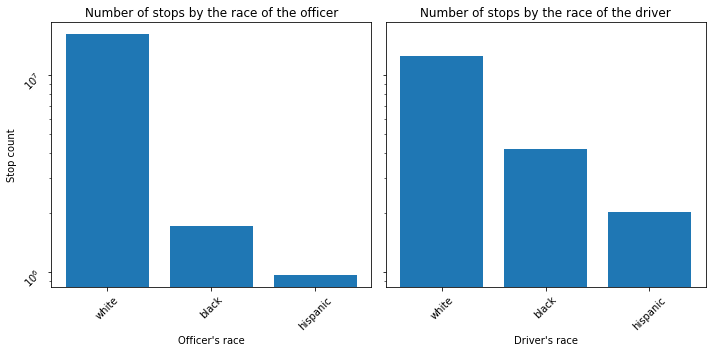

In [29]:
stat = stat.sort_values(by=['stop_count'], ascending=False)
# Plot number of stops performed by each officer race
df = stat.query("officer_race!='all' and subject_race=='all'")
# Plot number of stops on each subject_race
df2 = stat.query("officer_race=='all' and subject_race!='all'")

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)

axes[0].bar(df['officer_race'], df['stop_count'], log=True)
axes[1].bar(df2['subject_race'], df2['stop_count'], log=True)

# Format
axes[0].set_ylabel('Stop count')
axes[0].set_xlabel("Officer's race")
axes[0].set_title('Number of stops by the race of the officer')
axes[0].tick_params(labelrotation=45)

axes[1].set_xlabel("Driver's race")
axes[1].set_title('Number of stops by the race of the driver')
axes[1].tick_params(labelrotation=45)

fig.tight_layout()

### b) Proportion of stops by officer race

In [30]:
stat.head(50)

,officer_race,subject_race,stop_count,proportions
0,all,all,18843347,1.000000
4,white,all,16173527,1.000000
1,all,white,12613455,0.669385
2,white,white,11232935,0.694526
3,white,opposite,4940592,0.305474
7,all,black,4221364,0.224024
5,white,black,3471998,0.214672
13,all,hispanic,2008528,0.106591
10,black,all,1712270,1.000000
6,white,hispanic,1468594,0.090802


TypeError: only size-1 arrays can be converted to Python scalars

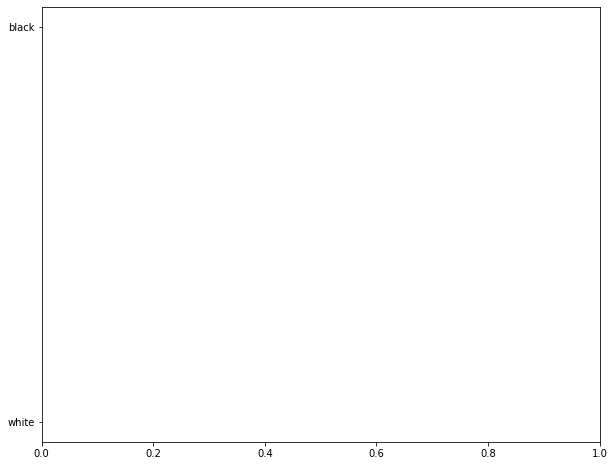

In [31]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Params for the plot aspect
colors = ["lightskyblue", 'deepskyblue', 'blue']

# Compute the left offset for each race
for race in races:
    left = 1
    for race2 in races:
        left = left - stat.loc[(stat['officer_race']==race) & (stat['subject_race']==race2), 'proportions'].to_numpy()[0]
        stat.loc[(stat['officer_race']==race) & (stat['subject_race']==race2), 'left'] = left

# Plot the barplot
for i in range(len(races)):
    df = stat[(stat['officer_race']!='all') & (stat['subject_race']==races[i])]
    ax.barh(df["officer_race"], df["proportions"], left=df["left"], label=races[i], color=colors[i])
    
    # Add values to the figure
    for row in df.iterrows(): 
        value = row[1]["proportions"]
        xcenter = row[1]["left"] + value/2
        ax.text(xcenter, row[1]['officer_race'], "{:.2f}".format(value* 100)+"%", ha='center', va='center', color="white", fontsize=14)
        
# Add a legend and informative axis label
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], mode="expand", frameon=True, loc='upper center', ncol=3, bbox_to_anchor=(0., 0.93, 1., .102),fontsize=12)
ax.set(xlim=(0, 1), xticks=[])
ax.set_xlabel(xlabel="Proportion of drivers stopped by race",fontsize=14)
ax.set_ylabel(ylabel="Officer's race",fontsize=14)
sns.despine(left=True, bottom=True)
f.savefig("figs/stopped_proportions", format="eps")

# 3. Search rates based on race

## 3.1 Data processing

Only keep the data we need for this part:

In [ ]:
data_search =  data[['county_name', 'state', 'officer_race', 'subject_race', 'search_conducted']]
data_search = data_search.dropna()

In [ ]:
data_search.head(10)

### a) Compute search rates by county for each subject race

In [ ]:
# Compute rate (either hit rate or search rate) of given variable
def computeRate(data, races, variable, column_names):
    rates = pd.DataFrame(columns=column_names)
    group = data.groupby(['county_name', 'state', 'officer_race'])
    
    for idx, df in group:
        for race in races:
            if variable == 'contraband_found':
                total = df[(df['search_conducted']==True) & (df['subject_race']==race)].shape[0]
            else :
                total = df[df['subject_race']==race].shape[0]
            positive = df.loc[(df[variable]==True) & (df['subject_race']==race)].shape[0]
            if total != 0:
                temp = pd.DataFrame([[idx[0], idx[1], idx[2], race, (positive/total), positive, total]], columns=rates.columns)
                rates = pd.concat([rates, temp], axis=0, ignore_index=True)
        
    return rates

In [ ]:
column_names=['county_name', 'state', 'officer_race', 'subject_race', 'search_rate', 'count_searched', 'total_stops']
rates = computeRate(data_search, races, 'search_conducted', column_names)
# Save data
rates.to_csv(r'data/search_rates.csv', index=False)
rates.head(10)

### b) Compute search rates for subjects of same & different race than that of the officer

In [ ]:
# Compute rate for variable for subject of same/different race than officer's race
def computeRateRace(data, variable, column_names):
    stats_race = pd.DataFrame(columns=column_names)
    group = data.groupby(['county_name', 'state', 'officer_race'])

    for idx, df in group:
        data_same = df.loc[df['subject_race']==idx[2]]
        rate_same = data_same[variable].to_numpy(dtype=np.float64)
        
        if rate_same.size > 0: # Some counties don't have data for some races
            data_diff = df.loc[df['subject_race']!=idx[2]]
            diff = data_diff[data.columns.tolist()[-2]].sum() # Sum of count_seached or count_contraband
            diff_tot = data_diff[data.columns.tolist()[-1]].sum() # Sum of total_stops or total_searches
            
            rate_diff = np.nan
            if diff_tot != 0: # Avoid division by 0
                rate_diff = diff / diff_tot
            temp = pd.DataFrame([[idx[0], idx[1], idx[2], True, rate_same[0],
                                  data_same[data.columns.tolist()[-2]].sum(), data_same[data.columns.tolist()[-1]].sum()],
                            [idx[0], idx[1], idx[2], False, rate_diff, diff, diff_tot]], columns=stats_race.columns)
            stats_race = pd.concat([stats_race, temp], axis=0, ignore_index=True)
        
    return stats_race

In [ ]:
column_names = ['county_name', 'state', 'officer_race', 'same_race_officer', 'search_rate', 'count_searched', 'total_stops']
stats_search = computeRateRace(rates,'search_rate', column_names)
stats_search.head(10)

### c) Data visualization

In [ ]:
# Plots the scatter plot
# Factor is used to scale the area
def plotScatter(ax, df, variable, race, factor):
    mask= "officer_race=='"+race+"'"
    same = df.query(mask+" and same_race_officer==True")
    diff = df.query(mask+" and same_race_officer==False")
    area = same[df.columns.tolist()[-2]].to_numpy(dtype=np.float64) + diff[df.columns.tolist()[-2]].to_numpy(dtype=np.float64)
    ax.scatter(same[variable] * 100, diff[variable] * 100, marker='o', color='None', alpha=1, edgecolor='k', linewidth=0.5, s=area * factor)
    
    # Add the line y=x
    lim = df.query(mask)[variable].max() * 100
    x = np.linspace(0,lim)
    ax.plot(x, x, ls='--', color='k', alpha=0.7)
    ax.set_xlabel(race+' officer and '+race+' driver')
    ax.set_ylabel(race+' officer and non '+race+' driver')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(races)):    
    plotScatter(axes[i], stats_search, 'search_rate', races[i], 0.2)
    
fig.tight_layout()
fig.savefig("figs/scatter_search", format="eps")

### d) Confidence intervals

In [ ]:
# Input: your array and the number of random samples (e.g., 1000 is a good number)
# Output: [lower error, upper error]

def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [ ]:
def computeCI(data, variable):
    ci = pd.DataFrame(columns=['officer_race', 'same_race_officer', 'lower_error', 'mean', 'upper_error'])

    for race in races:
        temp_same = data[(data['officer_race']==race) & data['same_race_officer']==True][variable]
        ci_temp_same = bootstrap_CI(temp_same, 1000)
        temp_diff = data[(data['officer_race']==race) & data['same_race_officer']==False][variable]
        ci_temp_diff = bootstrap_CI(temp_diff, 1000)
        temp = pd.DataFrame([[race, True, ci_temp_same[0], temp_same.mean(), ci_temp_same[1]],
                            [race, False, ci_temp_diff[0], temp_diff.mean(), ci_temp_diff[1]]], columns=ci.columns)
        ci = pd.concat([ci, temp], ignore_index=True)
    return ci

In [ ]:
ci_search = computeCI(stats_search, 'search_rate')
ci_search.head(10)

# 4. Hit rates based on race

Only keep the data we need for this part:

In [ ]:
data_hit = data[['county_name', 'state', 'officer_race', 'subject_race', 'search_conducted', 'contraband_found']]
data_hit = data_hit.dropna()

### a) Compute hit rates by county for each subject race

In [ ]:
column_names=['county_name', 'state', 'officer_race', 'subject_race', 'hit_rate', 'count_contraband', 'total_searches']
hit = computeRate(data_hit, races, 'contraband_found', column_names)

# Save data
hit.to_csv(r'data/hit_rates.csv', index=False)
hit.head(10)

### b) Compute hit rates for subjects of same & different race than that of the officer

In [ ]:
column_names = ['county_name', 'state', 'officer_race', 'same_race_officer', 'hit_rate', 'count_contraband', 'total_searches']
stats_hit = computeRateRace(hit,'hit_rate', column_names)
stats_hit.head(10)

### c) Data visualization

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(races)):    
    plotScatter(axes[i], stats_hit, 'hit_rate',races[i], 1)
    
fig.tight_layout()
fig.savefig("figs/scatter_hit", format="eps")

### d) Confidence intervals

In [ ]:
ci_hit = computeCI(stats_hit, 'hit_rate')
ci_hit.head(10)

### c) Student t-test

In [ ]:
def ttest(data, races):
    df = pd.DataFrame(columns=['officer_race', 'mean_same_race', 'mean_diff_race', 't-statistic', 'p-value'])
    for race in races:
        same_race = data[(data['officer_race']==race) & (data['same_race_officer']==True)]['hit_rate']
        diff_race = data[(data['officer_race']==race) & (data['same_race_officer']==False)]['hit_rate']
        result = stats.ttest_ind(same_race, diff_race)
        temp = pd.DataFrame([[race, same_race.mean(), diff_race.mean(), result[0], result[1]]], columns=df.columns)
        df = pd.concat([df, temp], ignore_index=True)
    return df

In [ ]:
stats_hit = stats_hit.dropna()
ttest_hit = ttest(stats_hit, races)
ttest_hit.head(10)

# 5. Search rate and hit rate based on officer race only

## a) Compute rates

In [ ]:
def computeRaceOfficer(data, column_names):
    stats_officer = pd.DataFrame(columns=column_names)
    group = data.groupby(['county_name', 'state', 'officer_race'])
    
    for idx, df in group:
        
        count = df.iloc[:, -2].sum() # Sum of count_searches / count_contraband
        total = df.iloc[:, -1].sum() # Sum of total_stops / total_searches
            
        if total != 0: # Avoid division by 0
            rate = count/total
            temp = pd.DataFrame([[idx[0], idx[1], idx[2], rate, count, total]], columns=column_names)
            stats_officer = pd.concat([stats_officer, temp], axis=0, ignore_index=True)
            
    return stats_officer

In [ ]:
# Search rate
column_names = ['county_name', 'state', 'officer_race', 'search_rate', 'count_searches', 'total_stops']
search_officer = computeRaceOfficer(rates, column_names)

search_officer.head(10)

In [ ]:
# Hit rate
column_names = ['county_name', 'state', 'officer_race', 'hit_rate', 'count_contraband', 'total_searches']
hit_officer = computeRaceOfficer(hit, column_names)

hit_officer.head(10)

## b) Visualization

In [ ]:
# Search rate
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

sns.boxplot(x="officer_race", y="search_rate",data=search_officer)
#sns.despine(offset=10, trim=True)
f.tight_layout()

In [ ]:
# Hit rate
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

sns.boxplot(x="officer_race", y="hit_rate",data=hit_officer)
#sns.despine(offset=10, trim=True)
f.tight_layout()
f.savefig("figs/boxplot_hit", format="eps")

# 6. Analysis of the stop rate

In this part, we will analyse the rate of white stops and the rate of black stops.

The **rate of white stops** is the rate for a white driver to bestopped by a police officer
The **rate of black stops** is the rate for a black driver to bestopped by a police officer

Our assumption is that in an unbiased environment, whites people should be stopped at the same rate as blacks people.

To compute the rate of white stops we will use the number of white drivers stopped in a County, and the number of whites registered in the Census data of that County. We will do the same for the rate of black stops

We will also split the rates into two groups: if the police officer race is white or black.

## a) Prepare datas

In [ ]:
# Load the stops datas
stop_rate_df = data[['county_name', 'state', 'subject_race', 'officer_race']].dropna()

stop_rate_df = stop_rate_df[(stop_rate_df['subject_race'] == 'white') | (stop_rate_df['subject_race'] == 'black')]
stop_rate_df = stop_rate_df[(stop_rate_df['officer_race'] == 'white') | (stop_rate_df['officer_race'] == 'black')]
# Compute the total number of stops per county and per races
stop_rate_df['total_stops'] = 1
data_total_stops = stop_rate_df.groupby(['county_name', 'state', 'subject_race', 'officer_race']).sum()

data_total_stops = data_total_stops.reset_index().dropna()
data_total_stops.head(5)


We can observe that the state in the police stops dataset is in the two letters Alpha code representation (i.e. AL). In the census dataset, the state columns contains the state name (i.e. Alabama).

A mapping dictionary has been found and used on github:https://gist.github.com/rogerallen/1583593



In [ ]:
# From https://gist.github.com/rogerallen/1583593
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))



In [ ]:
data_states_mapped = data_total_stops.copy()
# Replace the state names
data_states_mapped['state'] = data_states_mapped['state'].map(abbrev_us_state)
# Create the cencus column for the cencus datas
data_states_mapped['cencus'] = data_states_mapped.apply(lambda x: getStatsByCounty(x['county_name'], x['state'], df), axis=1)

# Display Thomas County entry
data_states_mapped[data_states_mapped['county_name'] == 'Thomas County']

We can observe that in the Florida dataset, there is one arrest in the Thomas County! This county is not in florida, but in Georgia, very close to the florida border. These entry will be removed. Same for the other counties registered in the wrong state.
The "Dillion County" from the police stops dataset has been misspelled, the real county name is "Dillon County". Same for "Claredon County" which is "Clarendon County".

In [ ]:
# Correct misspeled county_name cencus data
# Dillon County
data_states_mapped.loc[data_states_mapped['county_name'] == 'Dillion County', 'cencus'] = \
data_states_mapped[data_states_mapped['county_name'] == 'Dillion County'].apply(lambda x: getStatsByCounty('Clarendon County', x['state'], df), axis=1)
# Clarendon County
data_states_mapped.loc[data_states_mapped['county_name'] == 'Claredon County', 'cencus'] = \
data_states_mapped[data_states_mapped['county_name'] == 'Claredon County'].apply(lambda x: getStatsByCounty('Clarendon County', x['state'], df), axis=1)

# Remove NaN cencus data (for instance Thomas County not been found in the Florida cencus datas)
data_states_mapped = data_states_mapped[data_states_mapped['cencus'].notna()]

data_states_mapped.head(5)

## B) Compute the rates

We will now extract the rate of black people stopped and the rate of white people stopped.

In [ ]:
# Return the rate of drivers stopped for a given race
def extractRate(race, total_stops, cencus_data):
    if race == 'black':
        return total_stops/cencus_data['black']
    else:
        return total_stops/cencus_data['white']

rates = data_states_mapped.copy()
rates['race_stop_rate'] = data_states_mapped.apply(lambda x: extractRate(x['subject_race'], x['total_stops'], x['cencus']) , axis=1)
rates.head(5)

In [ ]:
# Cleaning
# Remove entries where the rate of black or white is "inf"
# That would mean that no black/white are registered in the cencus dataset
county_to_remove = rates[False == rates['race_stop_rate'].replace([np.inf, -np.inf], np.nan).notna()]['county_name'].values
length_before = len(rates);
rates = rates[False == rates['county_name'].isin(county_to_remove)]

print((length_before - len(rates))/2, " counties removed");
print(rates['county_name'].value_counts().count() ," counties will be analyzed from ",rates['state'].value_counts().count(), " different states: ", rates['state'].value_counts().index.tolist())

In [ ]:
# Display some general stats about the rates

rates_black_officer = rates[rates['officer_race'] == 'black'].copy()
rates_white_officer = rates[rates['officer_race'] == 'white'].copy()

# officer black
black_stop_rate_officer_black = rates_black_officer[rates_black_officer['subject_race'] == 'black']['race_stop_rate']
white_stop_rate_officer_black = rates_black_officer[rates_black_officer['subject_race'] == 'white']['race_stop_rate']

# officer white
black_stop_rate_officer_white = rates_white_officer[rates_white_officer['subject_race'] == 'black']['race_stop_rate']
white_stop_rate_officer_white = rates_white_officer[rates_white_officer['subject_race'] == 'white']['race_stop_rate']

print("Black stop rate by black officer. [mean]=", black_stop_rate_officer_black.mean(), "[std]=", black_stop_rate_officer_black.std())
print("White stop rate by black officer. [mean]=", white_stop_rate_officer_black.mean(), "[std]=", white_stop_rate_officer_black.std())
print("Black stop rate by white officer. [mean]=", black_stop_rate_officer_white.mean(), "[std]=", black_stop_rate_officer_white.std())
print("White stop rate by white officer. [mean]=", white_stop_rate_officer_white.mean(), "[std]=", white_stop_rate_officer_white.std())


### Observation
#### Black officer
We can observe that black officers seems to arrest black and white people at a similar rate

#### White officer
We can observe that white officers tends to arrest black people at a higher rate than white people.

#### Note
The observed stop rate is different than the one in the paper, since here we are using all the stops datas. In the paper, the stop rate is the average annual per-capita stop rates across the states and cities analysed. The rate can be greater than 1 since the stop data are for many years, and may be greater than the number of inhabitants registered in the census dataset.

## C. Difference in the stops rates for each County

In this part, we will analyse how many counties have a black stop rate greater than the black stop rate.

For that, we will use a ratio:
$ ratio = white\_stop\_rate / black\_stop\_rate $

If $ratio > 1$, the whites drivers are arrested more often that the black drivers
if $ratio < 1$, the blacks drivers are arrested more often.

In [ ]:
# We now have the rate of black people stopped and the rate of white people stopped
# We will now compute the ratio of those two different rates
# ratio = r_white / w_black

# If we have ratio > 1:  The rate of white stopped is greater than the rate of black stopped
# If we have ration < 0: The rate of black stopped is greater than the rate of white stopped

def computeRatio(white_rate, black_rate):
    return white_rate / black_rate;

def extract_ratio(race, race_stop_rate):
    if (len(race_stop_rate) != 2):
        return None;
    if(race.iloc[0] == 'white'):
        return computeRatio(race_stop_rate.iloc[0], race_stop_rate.iloc[1])
    else:
        return computeRatio(race_stop_rate.iloc[1], race_stop_rate.iloc[0])

def appl_merge_rows(x):
    ratio = extract_ratio(x['subject_race'], x['race_stop_rate'])
    return pd.Series({'total_stops':x['total_stops'].sum(), 'ratio':ratio, 'cencus': x['cencus'].values[0]})
    
ratios = rates.groupby(['county_name', 'state', 'officer_race']).apply(lambda x: appl_merge_rows(x))

# remove NaN values
# for instance if there is no stops between "black officer and black subject" in a county, the ratio is NaN
ratios = ratios[ratios['ratio'].notna()].reset_index();

ratios_black_officer = ratios[ratios['officer_race'] == 'black'];
ratios_white_officer = ratios[ratios['officer_race'] == 'white'];

ratios.head(5)

In [ ]:
# Display some stats about the rates
print("Number of Counties with white_stop_rate > black_stop_rate (officer black): ", len(ratios_black_officer[ratios_black_officer['ratio'] > 1]))
print("Number of Counties with white_stop_rate < black_stop_rate (officer black): ", len(ratios_black_officer[ratios_black_officer['ratio'] < 1]))

print("Number of Counties with white_stop_rate > black_stop_rate (officer white): ", len(ratios_white_officer[ratios_white_officer['ratio'] > 1]))
print("Number of Counties with white_stop_rate < black_stop_rate (officer white): ", len(ratios_white_officer[ratios_white_officer['ratio'] < 1]))


warnings.filterwarnings('ignore')

# Display two distibution plots, classified by police officer race
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.distplot(ratios_white_officer['ratio'].values, ax=axes[0])
sns.distplot(ratios_black_officer['ratio'].values, ax=axes[1])
plt.title('Distribution of the ratios.')
axes[0].set_ylim(ymax=1.3)
axes[0].set_xlim(xmax=4)
axes[0].set_title('White officer')
axes[1].set_ylim(ymax=1.3)
axes[1].set_xlim(xmax=4)
axes[1].set_title('Black officer')

axes[0].axvline(x=1, color='red')
axes[1].axvline(x=1, color='red')

axes[0].set_xlabel('Ratio')
axes[1].set_xlabel('Ratio')
axes[0].set_ylabel('Density')

plt.show()

print("Info: Ratio > 1 when the rate of white stops is greater than the rate of black stops")

#### Observation

We can observe that the black stops rate is often greater than the white stops rate (ratio < 1).

It seems that the officer race does not make a significant difference at the County level.


In [ ]:
np.random.seed(142)

# Display the ratio for each county
# Each circle is a city, wheited by the number of datas

# reduce the size of the total_stops column
total_stops = (ratios['total_stops']/ratios['total_stops'].mean())

def ratioPlot(df, ax):
    N = len(df)
    x = np.random.rand(N)*3
    y = np.random.rand(N)*3
    colors = np.random.rand(N)
    area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

    return ax.scatter(x, y, alpha = .8, s=df['total_stops'].values/1000, c = df['ratio'].values, cmap = 'seismic')
    
fig, axes = plt.subplots(1, 2, figsize=(18,6))

im = ratioPlot(ratios[ratios['officer_race'] == 'white'], axes[0])   

ratioPlot(ratios[ratios['officer_race'] == 'black'], axes[1])   

fig.subplots_adjust(right=0.8)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Ratio: (white_stop_rate / black_stop_rate)')

axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[1].set_yticklabels([])
axes[1].set_xticklabels([])
axes[0].set_title('White officer')
axes[1].set_title('Black officer')


#### Observation
In the figure above, we can observe a lot of blue circles. Each circle is a County and the area of the circle is defined by the number of stops in the County.

We can observe that at the county level, the black stop rate is higher than the white stop rate. Further more, the black officer rate does seems to reverse this balance. 

##### Stop rate analysis conclusion
These numbers are a starting point for understanding racial disparities in traffic stops, but they do not, per se, provide strong evidence of racially disparate treatment. In particular, stop rates do
not account for possible race-specific differences in driving behaviour,
including amount of time spent on the road and adherence to traffic
laws. For example, if black drivers, hypothetically, spend more time on
the road than white drivers, that could explain the higher stop rates we
see for the former, even in the absence of discrimination. 